<h1><center> Расчет налоговой базы "Метод FIFO"</center></h1>

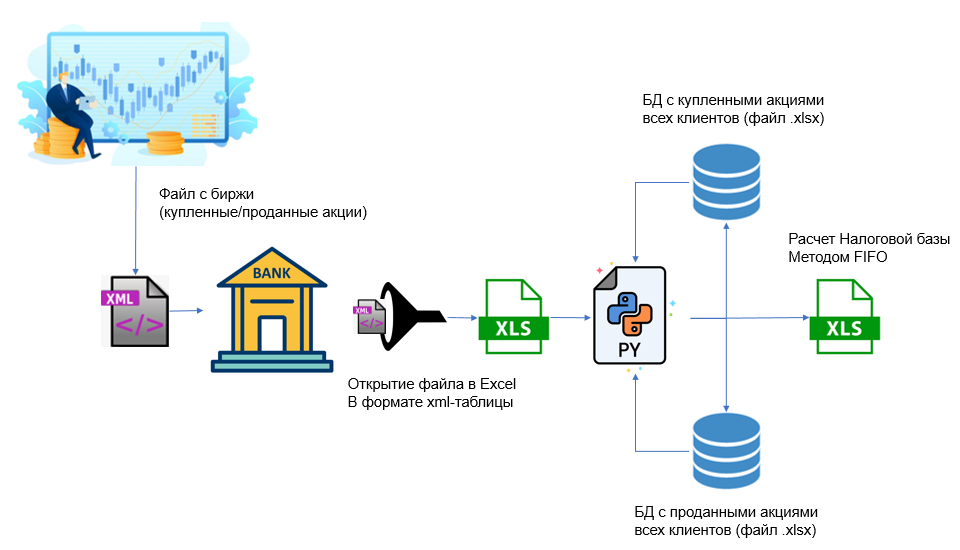

In [1]:
import time
import requests
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
from xml.dom import minidom
import pandas as pd
import datetime as DT
from IPython.display import display
import numpy as np
from pandas.io.excel import ExcelWriter
import openpyxl
#import decimal as decimal
import math
from decimal import Decimal, ROUND_HALF_UP

## Обновление БД файлами с биржи

**1.1 Прочитаем файлы с биржи в DataFrame**

In [2]:
# Функция округления https://translated.turbopages.org/proxy_u/en-ru.ru.e95f496a-629d4e1b-3e54409a-74722d776562/https/stackoverflow.com/questions/33019698/how-to-properly-round-up-half-float-numbers/53329223#53329223
def round_half_up(x: float, num_decimals: int) -> float:
    if num_decimals < 0:
        raise ValueError("Num decimals needs to be at least 0.")
    target_precision = "1." + "0" * num_decimals
    rounded_x = float(Decimal(str(x)).quantize(Decimal(target_precision), ROUND_HALF_UP))
    return rounded_x

In [3]:
# Выпишим необходимые наименования столбцов для DF
columns = ['DOC_DATE', 'DOC_TIME', 'DOC_NO', 'DOC_TYPE_ID', 'SENDER_ID','RECEIVER_ID', \
           'ReportDate', 'Weekday', 'MainFirmId', 'FirmName',\
           'FirmID', 'ClientCode', 'ClientDetails', 'CurrencyId',\
       'CurrencyName', 'InfType', 'ClearingType', 'Session', 'SettleDate',\
       'InstrType', 'BoardId', 'BoardName', 'SecurityId', 'ISIN',\
       'SecShortName', 'PriceType', 'RecNo', 'TradeNo', 'TradeDate',\
       'TradeTime', 'BuySell', 'SettleCode', 'Decimals', 'Price',\
       'Quantity', 'Value', 'AccInt', 'Amount', 'Balance', 'TrdAccId',\
       'CPFirmId', 'CPFirmShortName', 'ReportTime', 'SettleTime',\
       'DueDate', 'EarlySettleStatus', 'RateType']

In [4]:
df_data = pd.DataFrame(columns = columns, index = range(0))
buy_full = pd.DataFrame(columns = columns, index = range(0))
sale_full = pd.DataFrame(columns = columns, index = range(0))

**1.2 Алгоритм добавления исторических биржевых файлов** 

- Если в файле будет одна строка с данными, то произойдет подстановка наименование колонок

In [5]:
for row in range(1,135):
    df = pd.read_excel('~/work/My Projects/Test_File/{:}.xlsx'.format(row))
    if len(df) == 0:
        values = df.columns.values
        df = pd.DataFrame(columns = columns, index = range(1))
        for j in range(0,len(values)):
            df[columns[j]]=values[j]  
    df_data = df_data.append(df,ignore_index = True)

**1.3 Разделим полученный DF на купленные и проданные акции** 

In [6]:
sale_full = df_data.loc[df_data['BuySell']=='S'].reset_index(drop=True)
buy_full = df_data.loc[df_data['BuySell']=='B'].reset_index(drop=True)

In [7]:
#Сделаем преобразование даты
sale_full['ReportDate'] = pd.to_datetime(sale_full['ReportDate']).dt.date
sale_full['SettleDate'] = pd.to_datetime(sale_full['SettleDate']).dt.date
sale_full['TradeDate'] = pd.to_datetime(sale_full['TradeDate']).dt.date
buy_full['ReportDate'] = pd.to_datetime(buy_full['ReportDate']).dt.date
buy_full['TradeDate'] = pd.to_datetime(buy_full['TradeDate']).dt.date
buy_full['SettleDate'] = pd.to_datetime(buy_full['SettleDate']).dt.date

In [8]:
#Сделаем преобразование даты
sale_full['ReportDate'] = pd.to_datetime(sale_full['ReportDate'])
sale_full['SettleDate'] = pd.to_datetime(sale_full['SettleDate'])
sale_full['TradeDate'] = pd.to_datetime(sale_full['TradeDate'])
buy_full['ReportDate'] = pd.to_datetime(buy_full['ReportDate'])
buy_full['TradeDate'] = pd.to_datetime(buy_full['TradeDate'])
buy_full['SettleDate'] = pd.to_datetime(buy_full['SettleDate'])

Для того, чтобы избавиться от дубликатов, необходимо сделать сортировку данных. 

Дата отчета должна быть равна Дате торгов
**ReportDate = TradeDate**

In [9]:
sale_full = sale_full.loc[sale_full['ReportDate']==sale_full['TradeDate']].reset_index(drop = True)
sale_full = sale_full.sort_values(by='TradeDate', ascending = True).reset_index(drop = True)

In [10]:
buy_full = buy_full.loc[buy_full['ReportDate']==buy_full['TradeDate']].reset_index(drop = True)
buy_full = buy_full.sort_values(by='TradeDate', ascending = True).reset_index(drop = True)

In [11]:
# Сохраним данные в файлы
buy_full_download = buy_full.loc[:,['ClientCode','TradeNo','ISIN','SecShortName','TradeDate','SettleDate',\
                                          'Quantity','Price','Value','AccInt','Amount']].reset_index(drop=True)
buy_full_download.columns = ['Код клиента','Номер сделки','ЦБ (ISIN)','ЦБ/наимен','Дата заключ сделки',\
                            'Дата расчетов','Штук','Цена','Обьем сделки покупки','НКД на дату исполнения',\
                            'Обязат./требования по ДС']
buy_full_download.to_excel('Покупка.xlsx')

sale_full_download = sale_full.loc[:,['ClientCode','TradeNo','ISIN','SecShortName','TradeDate','SettleDate',\
                                          'Quantity','Price','Value','AccInt','Amount']].reset_index(drop=True)
sale_full_download.columns =  ['Код клиента','Номер сделки','ЦБ (ISIN)','ЦБ/наимен','Дата заключ сделки (выбыт.)',\
                            'Дата расчетов (выбыт.)','Штук выбыл.','Цена выбыт.','Обьем сделки продажи','НКД на дату исполнения',\
                            'Обязат./требования по ДС']
sale_full_download.to_excel('Продажа.xlsx')

**1.4 Создадим необходимую структуру файлов для загрузки**
- Код клиента - ClientCode	
- Регистрационный номер - ISIN (переименовать в цб isin)
- ЦБ/наимен - (Из расширенного списка по коду ISIN)
- Дата заключ сделки - TradeDate
- Дата расчетов - SettleDate
- Штук - Quantity
- Цена - Price
- НКД на дату исполнения - AccInt 
- Покупка/Продажа - BuySell

In [12]:
# Массив buy
buy_stock_market = buy_full.loc[:,['ClientCode','TradeNo','ISIN','SecShortName','TradeDate','SettleDate',\
                                          'Quantity','Price','Value','AccInt','Amount']].reset_index(drop=True)

In [13]:
# Массив sale
sale_stock_market = sale_full.loc[:,['ClientCode','TradeNo','ISIN','SecShortName','TradeDate','SettleDate',\
                                          'Quantity','Price','Value','AccInt','Amount']].reset_index(drop=True)

**1.5 Заменим наименование столбцов на стандартный формат**

In [14]:
buy_stock_market.columns = ['Код клиента','Номер сделки','ЦБ (ISIN)','ЦБ/наимен','Дата заключ сделки',\
                            'Дата расчетов','Штук','Цена','Обьем сделки покупки','НКД на дату исполнения',\
                            'Обязат./требования по ДС']

In [15]:
sale_stock_market.columns = ['Код клиента','Номер сделки','ЦБ (ISIN)','ЦБ/наимен','Дата заключ сделки (выбыт.)',\
                            'Дата расчетов (выбыт.)','Штук выбыл.','Цена выбыт.','Обьем сделки продажи','НКД на дату исполнения',\
                            'Обязат./требования по ДС']

In [16]:
# Количество сделок покупки клиентов
print("Количество сделок покупки: {:}".format(len(buy_stock_market)))
print("Количество сделок продажи: {:}".format(len(sale_stock_market)))

Количество сделок покупки: 7250
Количество сделок продажи: 10570


**1.6 Добавим справочник тариф=клиент**

In [17]:
client_commissions_data = pd.ExcelFile('Справочники.xlsx')
client_commissions_data = client_commissions_data.parse("Справочник")
client_commissions_data['Тариф, %'] = client_commissions_data['Тариф, %']/100
client_commissions_data.columns = ['Код клиента', 'Тариф']

**1.7 Расчет комиссии брокера по купленным и проданным акциям**

1. Создадим отдельный массив с купленными и проданными акциями.
2. Посчитаем по каждой сделке коммиссию покупки и продажи

Далее, полученную комиссию по сделкам будем сравнивать при расчет налоговой базы методом ФИФО. Так как одна сделка может разбиться на 2 и более, то в ходе разбиения происходит неточное разбиение комиссии.

**Как это происходит:**

Так как объем сделки имеет тип float, и может хранить в себе 2 и более знака после запятой, а округление происходит до 2-ух знаков после запятой, то при разбитии сделки например на 10 сделок, происходит потеря сотых. Далее будет описан алгоритм корректировки коммиссии брокера. 

In [48]:
#Сделаем сортировку от более ранних акций к более новым
buy_stock_com = buy_stock_market.sort_values(by = 'Дата заключ сделки',ascending = True).reset_index(drop = True)
sale_stock_com = sale_stock_market.sort_values(by = 'Дата заключ сделки (выбыт.)',ascending = True).reset_index(drop = True)

In [49]:
# Добавим тарифный план по клиентам
for row in client_commissions_data['Код клиента']:
    for i in range (0,len(buy_stock_com)):
        if buy_stock_com.loc[i]['Код клиента'] == row:
            buy_stock_com.loc[i,'Тариф'] = \
            client_commissions_data.loc[client_commissions_data['Код клиента']==row]['Тариф'].values

In [50]:
# Добавим тарифный план по клиентам
for row in client_commissions_data['Код клиента']:
    for i in range (0,len(sale_stock_com)):
        if sale_stock_com.loc[i]['Код клиента'] == row:
            sale_stock_com.loc[i,'Тариф'] = \
            client_commissions_data.loc[client_commissions_data['Код клиента']==row]['Тариф'].values

Посчитаем комиссию, округлим полученный результат до 2-ух знаков после запятой

In [51]:
for row in range(0,len(buy_stock_com)):
    revenue = buy_stock_com.loc[row,'Цена']*buy_stock_com.loc[row,'Штук']
    revenue = round_half_up(revenue,2)
    com = revenue*buy_stock_com.loc[row,'Тариф']
    buy_stock_com.loc[row,'Комиссия брокера']  = round_half_up(com,2)

In [52]:
for row in range(0,len(sale_stock_com)):
    revenue = sale_stock_com.loc[row,'Цена выбыт.']*sale_stock_com.loc[row,'Штук выбыл.']
    revenue = round_half_up(revenue,2)
    com = revenue*sale_stock_com.loc[row,'Тариф']
    sale_stock_com.loc[row,'Комиссия брокера']  = round_half_up(com,2)

## Сбор таблиц для метода FIFO

In [53]:
buy_stock = buy_stock_market.loc[:,['Код клиента','Номер сделки','ЦБ (ISIN)','ЦБ/наимен','Дата заключ сделки',\
                            'Дата расчетов','Штук','Цена','Обьем сделки покупки','НКД на дату исполнения',\
                            'Обязат./требования по ДС']]
buy_stock = buy_stock.sort_values(by = 'Дата заключ сделки', ascending = True).reset_index(drop = True)

In [54]:
sale_stock = sale_stock_market.loc[:,['Код клиента','Номер сделки','ЦБ (ISIN)','ЦБ/наимен','Дата заключ сделки (выбыт.)',\
                            'Дата расчетов (выбыт.)','Штук выбыл.','Цена выбыт.','Обьем сделки продажи','НКД на дату исполнения',\
                            'Обязат./требования по ДС']]
sale_stock = sale_stock.sort_values(by = 'Дата заключ сделки (выбыт.)', ascending = True).reset_index(drop = True)

**2.1 Создадим индивидуальный список клиентов клиент=акция**

In [55]:
client_stock = sale_stock.loc[:,['Код клиента','ЦБ (ISIN)','ЦБ/наимен']].drop_duplicates().reset_index(drop=True)

**2.2 Создадим новый столбец НКД на штуку для расчета прибыли по ОФЗ**

In [56]:
for i in range(0, len(buy_stock)):
    if buy_stock.loc[i,'НКД на дату исполнения'] == 0:
        buy_stock.loc[i,'НКД на штуку'] = 0
    else:
        buy_stock.loc[i,'НКД на штуку']=buy_stock.loc[i,'НКД на дату исполнения']/buy_stock.loc[i,'Штук']

**2.3 Создадим общий список клиент buy=sale по одиноковому количеству акций**

In [57]:
# Цикл прохода по клиенту/акции
buy_sale_full =[]
for k in client_stock['Код клиента'].unique():
    # Создадим массив клиент=акция для расчета ФИФО
    for j in client_stock.loc[client_stock['Код клиента']==k]['ЦБ (ISIN)'].unique():
        
        buy = buy_stock.loc[(buy_stock['Код клиента']==k)&(buy_stock['ЦБ (ISIN)']==j)].reset_index(drop=True)
        buy = buy.sort_values(by = ['Дата заключ сделки','Номер сделки'], ascending = [True,True]).reset_index(drop=True)
        
        sale = sale_stock.loc[(sale_stock['Код клиента']==k)&(sale_stock['ЦБ (ISIN)']==j)].reset_index(drop=True)
        sale = sale.sort_values(by =['Дата заключ сделки (выбыт.)','Номер сделки'], ascending = [True,True]).reset_index(drop = True)
        
        if buy['Штук'].sum()<sale['Штук выбыл.'].sum():
            print(k,j,buy['Штук'].sum(),sale['Штук выбыл.'].sum())       
        # Цикл по расчету ФИФО
        buy_sale = []
        row = 0
        row_1 = 0
        i = 0
        while True:
            # Условие выхода из цикла
            if sale.iloc[-1]['Штук выбыл.']==0:
                break
                
                # Условие, когда в строке покупки болеше акций, чем в строке продажи    
            if (buy.loc[row,'Штук']-sale.loc[row_1,'Штук выбыл.']) > 0:
                
                # Создание массива Покупка-Продажа по строкам с ценой для расчета FIFO.
                buy_sale.append(buy.loc[row].values)

                # Добавление полученных данных в общий массив
                buy_sale = np.append(buy_sale,sale.loc[row_1,['Код клиента','Номер сделки','ЦБ (ISIN)',\
                            'Дата заключ сделки (выбыт.)','Дата расчетов (выбыт.)','Штук выбыл.','Цена выбыт.',\
                            'Обьем сделки продажи','НКД на дату исполнения','Обязат./требования по ДС']].values)
                # Замена 6 элемента в массиве
                buy_sale[6] = sale.loc[row_1,'Штук выбыл.']
                # Добавление данных в конечный массив купли/продажи
                buy_sale_full.append(buy_sale)
                buy_sale = []

                 # Замена значения в исходном массиве
                buy.loc[row,'Штук'] = buy.loc[row,'Штук']-sale.loc[row_1,'Штук выбыл.']
                sale.loc[row_1,'Штук выбыл.'] = sale.loc[row_1,'Штук выбыл.']-sale.loc[row_1,'Штук выбыл.'] 
                row_1 +=1
                
            elif (buy.loc[row,'Штук']-sale.loc[row_1,'Штук выбыл.']) < 0:

                # Создание массива Покупка-Продажа по строкам с ценой для расчета FIFO.

                buy_sale.append(buy.loc[row].values)

                buy_sale = np.append(buy_sale,sale.loc[row_1,['Код клиента','Номер сделки','ЦБ (ISIN)',\
                            'Дата заключ сделки (выбыт.)','Дата расчетов (выбыт.)','Штук выбыл.','Цена выбыт.',\
                            'Обьем сделки продажи','НКД на дату исполнения','Обязат./требования по ДС']].values)
                # Замена 17 элемента в массиве
                buy_sale[17] = buy.loc[row,'Штук']
                
                buy_sale_full.append(buy_sale)
                buy_sale = []
                        # Замена значения в исходном массиве        
                sale.loc[row_1,'Штук выбыл.'] = sale.loc[row_1,'Штук выбыл.']-buy.loc[row,'Штук']
                buy.loc[row,'Штук']=0
                row +=1
                
            elif (buy.loc[row,'Штук']-sale.loc[row_1,'Штук выбыл.']) == 0:

                # Создание массива Покупка-Продажа по строкам с ценой для расчета FIFO.

                buy_sale.append(buy.loc[row].values)

                buy_sale = np.append(buy_sale,sale.loc[row_1,['Код клиента','Номер сделки','ЦБ (ISIN)',\
                            'Дата заключ сделки (выбыт.)','Дата расчетов (выбыт.)','Штук выбыл.','Цена выбыт.',\
                            'Обьем сделки продажи','НКД на дату исполнения','Обязат./требования по ДС']].values)
                
                buy_sale_full.append(buy_sale)
                buy_sale = []
                        # Замена значения в исходном массиве
                buy.loc[row,'Штук'] = buy.loc[row,'Штук']-sale.loc[row_1,'Штук выбыл.']
                sale.loc[row_1,'Штук выбыл.'] = sale.loc[row_1,'Штук выбыл.']-sale.loc[row_1,'Штук выбыл.']
                row_1 +=1
                row+=1
            i+=1

In [28]:
# Зададим наименование столбцов полученного массива данных
columns = ['Код клиента','Номер сделки','ЦБ (ISIN)','ЦБ/наимен','Дата заключ сделки',\
                            'Дата расчетов','Штук','Цена','Обьем сделки покупки','НКД на дату исполнения',\
                'Обязат./требования по ДС','НКД на штуку','Код клиента_1','Номер сделки_1','ЦБ (ISIN)',\
                            'Дата заключ сделки (выбыт.)','Дата расчетов (выбыт.)','Штук выбыл.','Цена выбыт.',\
                            'Обьем сделки продажи','НКД на дату исполнения','Обязат./требования по ДС']

In [29]:
buy_sale_FIFO = pd.DataFrame(buy_sale_full, columns = columns)

In [30]:
buy_sale_FIFO.head()

,Код клиента,Номер сделки,ЦБ (ISIN),ЦБ/наимен,Дата заключ сделки,Дата расчетов,Штук,Цена,Обьем сделки покупки,НКД на дату исполнения,...,Код клиента_1,Номер сделки_1,ЦБ (ISIN),Дата заключ сделки (выбыт.),Дата расчетов (выбыт.),Штук выбыл.,Цена выбыт.,Обьем сделки продажи,НКД на дату исполнения,Обязат./требования по ДС
0,ANZ28092021,4453477985,US5603172082,MAIL-гдр,2021-09-30,2021-10-04,2,1497.80,7489.0,0.0,...,ANZ28092021,4535016802,US5603172082,2021-10-20,2021-10-22,2,1583.80,3167.6,0.0,3167.6
1,ANZ28092021,4453477985,US5603172082,MAIL-гдр,2021-09-30,2021-10-04,3,1497.80,7489.0,0.0,...,ANZ28092021,4535016803,US5603172082,2021-10-20,2021-10-22,3,1583.80,4751.4,0.0,4751.4
2,ANZ28092021,4453504861,RU0008943394,Ростел -ао,2021-09-30,2021-10-04,10,90.90,4545.0,0.0,...,ANZ28092021,4878281565,RU0008943394,2022-01-18,2022-01-20,10,77.36,773.6,0.0,773.6
3,ANZ28092021,4453504861,RU0008943394,Ростел -ао,2021-09-30,2021-10-04,40,90.90,4545.0,0.0,...,ANZ28092021,4878281566,RU0008943394,2022-01-18,2022-01-20,40,77.35,3094.0,0.0,3094.0
4,ANZ28092021,4453448611,RU0009062285,Аэрофлот,2021-09-30,2021-10-04,100,69.92,6992.0,0.0,...,ANZ28092021,4878277825,RU0009062285,2022-01-18,2022-01-20,100,57.96,11592.0,0.0,11592.0


## Считаем налог "Метод ФИФО"

In [31]:
# Добавление тариф по клиентам в файл buy_sale_FIFO
for row in client_commissions_data['Код клиента']:
    for i in range (0,len(buy_sale_FIFO)):
        #print(buy_sale_FIFO.loc[i]['Код клиента'==row])
        if buy_sale_FIFO.loc[i]['Код клиента'].rstrip() == row:
            buy_sale_FIFO.loc[i,'Тариф'] = \
            client_commissions_data.loc[client_commissions_data['Код клиента']==row]['Тариф'].values

**3.1 Посчитаем комиссию, округлим полученный результат до 2-ух знаков после запятой**

In [32]:
for row in range(0, len(buy_sale_FIFO)):
    revenue = buy_sale_FIFO.loc[row,'Штук']*buy_sale_FIFO.loc[row,'Цена']
    revenue = round_half_up(revenue,2)
    com_buy = revenue*buy_sale_FIFO.loc[row,'Тариф']
    buy_sale_FIFO.loc[row,'Комиссия покупки'] = round_half_up(com_buy,2)
    revenue_1 = buy_sale_FIFO.loc[row,'Штук выбыл.']*buy_sale_FIFO.loc[row,'Цена выбыт.']
    revenue_1 = round_half_up(revenue_1,2)
    com_sale = revenue_1*buy_sale_FIFO.loc[row,'Тариф']
    buy_sale_FIFO.loc[row,'Комиссия продажи'] = round_half_up(com_sale,2)

**3.2 Произведем сверку комиссии по купленным акциям**

In [58]:
# Сверка комиссии покупки
for row in buy_sale_FIFO['Номер сделки'].unique():
    if buy_stock_com.loc[buy_stock_com['Номер сделки']==row]['Штук'].sum() ==\
    buy_sale_FIFO.loc[buy_sale_FIFO['Номер сделки']==row]['Штук'].sum():
            # "Исходная комиссия больше"
        if (buy_stock_com.loc[buy_stock_com['Номер сделки']==row]['Комиссия брокера'].sum() -\
    buy_sale_FIFO.loc[buy_sale_FIFO['Номер сделки']==row]['Комиссия покупки'].sum())>0:
            # Найдем разницу
            com_brok = buy_stock_com.loc[buy_stock_com['Номер сделки']==row]['Комиссия брокера'].sum()
            com_buy = buy_sale_FIFO.loc[buy_sale_FIFO['Номер сделки']==row]['Комиссия покупки'].sum()
            otk = com_brok - com_buy
            
            #print(otk)
            # Найдем индекс для перезаписи значения
            ind = buy_sale_FIFO.loc[buy_sale_FIFO['Номер сделки']==row]['Комиссия покупки'].index.min()
            #print('Значение до',buy_sale_FIFO.loc[ind,'Комиссия покупки'])
            correct_value = buy_sale_FIFO.loc[ind,'Комиссия покупки'] + otk
            buy_sale_FIFO.loc[ind,'Комиссия покупки'] = round_half_up(correct_value,2)

            #print('Значение после',buy_sale_FIFO.loc[ind,'Комиссия покупки'])
            
            # "Исходная комиссия меньше"
        elif(buy_stock_com.loc[buy_stock_com['Номер сделки']==row]['Комиссия брокера'].sum() -\
    buy_sale_FIFO.loc[buy_sale_FIFO['Номер сделки']==row]['Комиссия покупки'].sum())<0:
            # Найдем разницу
            com_brok = buy_stock_com.loc[buy_stock_com['Номер сделки']==row]['Комиссия брокера'].sum()
            com_buy = buy_sale_FIFO.loc[buy_sale_FIFO['Номер сделки']==row]['Комиссия покупки'].sum()
            otk = com_brok - com_buy
            
            #print(otk)
            # Найдем индекс для перезаписи значения
            ind = buy_sale_FIFO.loc[buy_sale_FIFO['Номер сделки']==row]['Комиссия покупки'].index.min()
            #print('Значение до',buy_sale_FIFO.loc[ind,'Комиссия покупки'])
            correct_value = buy_sale_FIFO.loc[ind,'Комиссия покупки'] + otk
            buy_sale_FIFO.loc[ind,'Комиссия покупки'] = round_half_up(correct_value,2)
            
            #print('Значение после',buy_sale_FIFO.loc[ind,'Комиссия покупки'])

**3.3 Произведем сверку комиссии по проданным акциям**

In [59]:
# Сверка комиссии продажи
for row in buy_sale_FIFO['Номер сделки_1'].unique():
    if sale_stock_com.loc[sale_stock_com['Номер сделки']==row]['Штук выбыл.'].sum() ==\
    buy_sale_FIFO.loc[buy_sale_FIFO['Номер сделки_1']==row]['Штук выбыл.'].sum():
            # "Исходная комиссия больше"
        if (sale_stock_com.loc[sale_stock_com['Номер сделки']==row]['Комиссия брокера'].sum() -\
    buy_sale_FIFO.loc[buy_sale_FIFO['Номер сделки_1']==row]['Комиссия продажи'].sum())>0:
            # Найдем разницу
            com_brok = sale_stock_com.loc[sale_stock_com['Номер сделки']==row]['Комиссия брокера'].sum()
            com_sale = buy_sale_FIFO.loc[buy_sale_FIFO['Номер сделки_1']==row]['Комиссия продажи'].sum()
            otk = com_brok - com_sale

            #print(otk)
            # Найдем индекс для перезаписи значения
            ind = buy_sale_FIFO.loc[buy_sale_FIFO['Номер сделки_1']==row]['Комиссия продажи'].index.min()
            #print('Значение до',buy_sale_FIFO.loc[ind,'Комиссия продажи'])
            correct_value = buy_sale_FIFO.loc[ind,'Комиссия продажи'] + otk
            buy_sale_FIFO.loc[ind,'Комиссия продажи'] = round_half_up(correct_value, 2)

            #print('Значение после',buy_sale_FIFO.loc[ind,'Комиссия продажи'])
            # "Исходная комиссия меньше"
        elif(sale_stock_com.loc[sale_stock_com['Номер сделки']==row]['Комиссия брокера'].sum() -\
    buy_sale_FIFO.loc[buy_sale_FIFO['Номер сделки_1']==row]['Комиссия продажи'].sum())<0:
            # Найдем разницу
            com_brok = sale_stock_com.loc[sale_stock_com['Номер сделки']==row]['Комиссия брокера'].sum()
            com_sale = buy_sale_FIFO.loc[buy_sale_FIFO['Номер сделки_1']==row]['Комиссия продажи'].sum()
            otk = com_brok - com_sale

            #print(otk)
            # Найдем индекс для перезаписи значения
            ind = buy_sale_FIFO.loc[buy_sale_FIFO['Номер сделки_1']==row]['Комиссия продажи'].index.min()
            #print('Значение до',buy_sale_FIFO.loc[ind,'Комиссия продажи'])
            correct_value = buy_sale_FIFO.loc[ind,'Комиссия продажи'] + otk
            buy_sale_FIFO.loc[ind,'Комиссия продажи'] = round_half_up(correct_value, 2)

            #print('Значение после',buy_sale_FIFO.loc[ind,'Комиссия продажи'])

**3.4 Посчитаем налоговую базу**

In [60]:
buy_sale_FIFO['Сумма покупки'] = buy_sale_FIFO['Цена']*buy_sale_FIFO['Штук']
buy_sale_FIFO['Сумма продажи'] = buy_sale_FIFO['Цена выбыт.']*buy_sale_FIFO['Штук выбыл.']

In [61]:
# Округление
for row in range(0,len(buy_sale_FIFO)):
    buy_sale_FIFO.loc[row,'Сумма покупки'] = round_half_up(buy_sale_FIFO.loc[row,'Сумма покупки'],2)
    buy_sale_FIFO.loc[row,'Сумма продажи'] = round_half_up(buy_sale_FIFO.loc[row,'Сумма продажи'],2)

In [62]:
# Расчет налоговой базы
buy_sale_FIFO['Налоговая база'] = buy_sale_FIFO['Сумма продажи']-buy_sale_FIFO['Сумма покупки']-\
buy_sale_FIFO['Комиссия покупки']- buy_sale_FIFO['Комиссия продажи']

In [63]:
# Сгруппируем данные по кдиентам
buy_sale_FIFO.groupby('Код клиента').\
agg({'Налоговая база':sum,'Комиссия покупки':sum,'Комиссия продажи':sum}).reset_index().head(2)

,Код клиента,Налоговая база,Комиссия покупки,Комиссия продажи
0,ANZ28092021,-2311.75,14.74,13.61
1,KAS29112021,2385.46,19.61,20.83


In [64]:
buy_sale_FIFO.to_excel('buy_sale_FIFO.xlsx')

# Вывод
Разработанная программа была собрана в Visual Studio при помощи pyinstaller

Данная программа была протестирована и внедрена. Используется отделом финансовых операций для расчета налоговой базы

Данный способ расчета будет использоваться до момента внедрения биржевого модуля